## Let's implement CCS from scratch.
This will deliberately be a simple (but less efficient) implementation to make everything as clear as possible.

In [1]:
from tqdm import tqdm
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression

# Let's just try IMDB for simplicity
data = load_dataset("amazon_polarity")["test"]

# Here are a few different model options you can play around with:
model_name = "deberta"
# model_name = "gpt-j"
# model_name = "t5"

# if you want to cache the model weights somewhere, you can specify that here
cache_dir = None

if model_name == "deberta":
    model_type = "encoder"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
    model = AutoModelForMaskedLM.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
    model.cuda()
elif model_name == "gpt-j":
    model_type = "decoder"
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
    model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
    model.cuda()
elif model_name == "t5":
    model_type = "encoder_decoder"
    tokenizer = AutoTokenizer.from_pretrained("t5-11b", cache_dir=cache_dir)
    model = AutoModelForSeq2SeqLM.from_pretrained("t5-11b", cache_dir=cache_dir)
    model.parallelize()  # T5 is big enough that we may need to run it on multiple GPUs
else:
    print("Not implemented!")

/home/asuka/anaconda3/envs/llm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset parquet (/home/asuka/.cache/huggingface/datasets/parquet/amazon_polarity-d48d00b6869479db/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|██████████| 2/2 [00:01<00:00,  1.50it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v2-xxlarge were not used when initializing DebertaV2ForMaskedLM: ['deberta.embeddings.position_embeddings.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.

## First let's write code for extracting hidden states given a model and text. 
How we do this exactly will depend on the type of model.

In [2]:
def get_encoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, truncation=True, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["hidden_states"]
    
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_encoder_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder-decoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
    decoder_text_ids = tokenizer("", return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, decoder_input_ids=decoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["encoder_hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given a decoder model and some text, gets the hidden states (in a given layer, by default the last) on that input text

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize (adding the EOS token this time)
    input_ids = tokenizer(input_text + tokenizer.eos_token, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(input_ids, output_hidden_states=True)

    # get the last layer, last token hidden states
    hs_tuple = output["hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()

    return hs

def get_hidden_states(model, tokenizer, input_text, layer=-1, model_type="encoder"):
    fn = {"encoder": get_encoder_hidden_states, "encoder_decoder": get_encoder_decoder_hidden_states,
          "decoder": get_decoder_hidden_states}[model_type]

    return fn(model, tokenizer, input_text, layer=layer)

## Now let's write code for formatting data and for getting all the hidden states.

In [3]:
def format_imdb(text, label):
    """
    Given an imdb example ("text") and corresponding label (0 for negative, or 1 for positive), 
    returns a zero-shot prompt for that example (which includes that label as the answer).
    
    (This is just one example of a simple, manually created prompt.)
    """
    return "The following movie review expresses a " + ["negative", "positive"][label] + " sentiment:\n" + text


def get_hidden_states_many_examples(model, tokenizer, data, model_type, n=100):
    """
    Given an encoder-decoder model, a list of data, computes the contrast hidden states on n random examples.
    Returns numpy arrays of shape (n, hidden_dim) for each candidate label, along with a boolean numpy array of shape (n,)
    with the ground truth labels
    
    This is deliberately simple so that it's easy to understand, rather than being optimized for efficiency
    """
    # setup
    model.eval()
    all_neg_hs, all_pos_hs, all_gt_labels = [], [], []

    # loop
    for _ in tqdm(range(n)):
        # for simplicity, sample a random example until we find one that's a reasonable length
        # (most examples should be a reasonable length, so this is just to make sure)
        while True:
            idx = np.random.randint(len(data))
            text, true_label = data[idx]["content"], data[idx]["label"]
            # the actual formatted input will be longer, so include a bit of a marign
            if len(tokenizer(text)) < 400:  
                break
                
        # get hidden states
        neg_hs = get_hidden_states(model, tokenizer, format_imdb(text, 0), model_type=model_type)
        pos_hs = get_hidden_states(model, tokenizer, format_imdb(text, 1), model_type=model_type)

        # collect
        all_neg_hs.append(neg_hs)
        all_pos_hs.append(pos_hs)
        all_gt_labels.append(true_label)

    all_neg_hs = np.stack(all_neg_hs)
    all_pos_hs = np.stack(all_pos_hs)
    all_gt_labels = np.stack(all_gt_labels)

    return all_neg_hs, all_pos_hs, all_gt_labels

In [4]:
neg_hs, pos_hs, y = get_hidden_states_many_examples(model, tokenizer, data, model_type)

100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


## Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if logistic regression accuracy is bad, there's no hope of CCS doing well.

In [5]:
# let's create a simple 50/50 train split (the data is already randomized)
n = len(y)
neg_hs_train, neg_hs_test = neg_hs[:n//2], neg_hs[n//2:]
pos_hs_train, pos_hs_test = pos_hs[:n//2], pos_hs[n//2:]
y_train, y_test = y[:n//2], y[n//2:]

# for simplicity we can just take the difference between positive and negative hidden states
# (concatenating also works fine)
x_train = neg_hs_train - pos_hs_train
x_test = neg_hs_test - pos_hs_test

lr = LogisticRegression(class_weight="balanced")
lr.fit(x_train, y_train)
print("Logistic regression accuracy: {}".format(lr.score(x_test, y_test)))

Logistic regression accuracy: 0.92


## Now let's try CCS

In [27]:
import matplotlib.pyplot as plt

class MLPProbe(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.linear1 = nn.Linear(d, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        o = self.linear2(h)
        return torch.sigmoid(o)

class CCS(object):
    def __init__(self, x0, x1, nepochs=1000, ntries=10, lr=1e-3, batch_size=-1, 
                 verbose=False, device="cuda", linear=True, weight_decay=0.01, var_normalize=False):
        # data
        self.var_normalize = var_normalize
        self.x0 = self.normalize(x0)
        self.x1 = self.normalize(x1)
        self.d = self.x0.shape[-1]

        # training
        self.nepochs = nepochs
        self.ntries = ntries
        self.lr = lr
        self.verbose = verbose
        self.device = device
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # probe
        self.linear = linear
        self.initialize_probe()
        self.best_probe = copy.deepcopy(self.probe)

        
    def initialize_probe(self):
        if self.linear:
            self.probe = nn.Sequential(nn.Linear(self.d, 1), nn.Sigmoid())
        else:
            self.probe = MLPProbe(self.d)
        self.probe.to(self.device)    


    def normalize(self, x):
        """
        Mean-normalizes the data x (of shape (n, d))
        If self.var_normalize, also divides by the standard deviation
        """
        normalized_x = x - x.mean(axis=0, keepdims=True)
        if self.var_normalize:
            normalized_x /= normalized_x.std(axis=0, keepdims=True)

        return normalized_x

        
    def get_tensor_data(self):
        """
        Returns x0, x1 as appropriate tensors (rather than np arrays)
        """
        x0 = torch.tensor(self.x0, dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.x1, dtype=torch.float, requires_grad=False, device=self.device)
        return x0, x1
    

    def get_loss(self, p0, p1):
        """
        Returns the CCS loss for two probabilities each of shape (n,1) or (n,)
        """
        informative_loss = (torch.min(p0, p1)**2).mean(0)
        consistent_loss = ((p0 - (1-p1))**2).mean(0)
        return informative_loss + consistent_loss


    def get_acc(self, x0_test, x1_test, y_test):
        """
        Computes accuracy for the current parameters on the given test inputs
        """
        x0 = torch.tensor(self.normalize(x0_test), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.normalize(x1_test), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        acc = (predictions == y_test).mean()
        acc = max(acc, 1 - acc)

        return acc
    
        
    def train(self):
        """
        Does a single training run of nepochs epochs
        """
        x0, x1 = self.get_tensor_data()
        permutation = torch.randperm(len(x0))
        x0, x1 = x0[permutation], x1[permutation]
        
        # set up optimizer
        optimizer = torch.optim.AdamW(self.probe.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        batch_size = len(x0) if self.batch_size == -1 else self.batch_size
        nbatches = len(x0) // batch_size

        # Start training (full batch)
        for epoch in range(self.nepochs):
            for j in range(nbatches):
                x0_batch = x0[j*batch_size:(j+1)*batch_size]
                x1_batch = x1[j*batch_size:(j+1)*batch_size]
            
                # probe
                p0, p1 = self.probe(x0_batch), self.probe(x1_batch)

                # get the corresponding loss
                loss = self.get_loss(p0, p1)

                # update the parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return loss.detach().cpu().item()
    
    def repeated_train(self):
        best_loss = np.inf
        for train_num in range(self.ntries):
            self.initialize_probe()
            loss = self.train()
            if loss < best_loss:
                self.best_probe = copy.deepcopy(self.probe)
                best_loss = loss

        return best_loss
    
    def supervised_train(self, labels, batch_size=-1, verbose=False, num_data_points=None, nepochs=0):
        """
        Trains the probe using the provided labels (0/1)
        Args:
            num_data_points: Number of data points to use for training. If None, use all data points.
        Returns both final loss and loss history
        """
        x0, x1 = self.get_tensor_data()
        x = torch.cat([x0, x1], dim=0)
        y = torch.tensor(np.concatenate([labels, labels]), dtype=torch.float, requires_grad=False, device=self.device).reshape(-1, 1)
        
        if num_data_points is not None and num_data_points < len(x):
            # Randomly select num_data_points data points
            indices = torch.randperm(len(x))[:num_data_points]
            x = x[indices]
            y = y[indices]
        
        # Check x and y values
        # Print a few examples to check data
        print("First 5 x values:", x[:5])
        print("First 5 y values:", y[:5])
        print("Shape of x:", x.shape)
        print("Shape of y:", y.shape)
        print("Unique y values:", torch.unique(y))
        
        # check the distributio of y
        print("Distribution of y values:", torch.bincount(y.flatten().long()))
        
        # set up optimizer
        optimizer = torch.optim.AdamW(self.probe.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        if batch_size == -1:
            batch_size = len(x)
        nbatches = len(x) // batch_size
        print(len(x), batch_size, nbatches)

        # Track loss history
        loss_history = []

        # Start training
        for epoch in tqdm(range(nepochs)):
            epoch_loss = 0.0
            # Randomly shuffle the data at each epoch
            perm = torch.randperm(len(x))
            x_shuffled = x[perm]
            y_shuffled = y[perm]
            
            for j in range(nbatches):
                x_batch = x_shuffled[j*batch_size:(j+1)*batch_size]
                y_batch = y_shuffled[j*batch_size:(j+1)*batch_size]

                # probe
                p = self.probe(x_batch)
                
                # check some of the model outputs in a batch
                # print("Model outputs (probabilities):", p[:5])
                # print("Corresponding labels:", y_batch[:5])

                # get the corresponding loss
                loss = F.binary_cross_entropy(p, y_batch)
                epoch_loss += loss.item()

                # update the parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Record average loss for this epoch
            loss_history.append(epoch_loss / nbatches)
            # Print loss for this epoch
            if verbose:
                print(f"Epoch {epoch+1}/{self.nepochs}, Loss: {epoch_loss / nbatches:.4f}")

        # visualize the loss_history
        # if verbose:
        plt.plot(loss_history)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss History")
        plt.show()

In [7]:
# Train CCS without any labels
ccs = CCS(neg_hs_train, pos_hs_train)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(neg_hs_test, pos_hs_test, y_test)
print("CCS accuracy: {}".format(ccs_acc))

CCS accuracy: 0.94


In [9]:
print(len(y_train), len(y_test))

50 50


First 5 x values: tensor([[ 0.0786,  0.1039,  0.2052,  ..., -0.2165,  0.1251, -0.2639],
        [-0.0629, -0.1365, -0.2764,  ...,  0.2124, -0.0936,  0.0724],
        [-0.1771,  0.1240, -0.3412,  ..., -0.3369,  0.0295, -0.0730],
        [-0.1743, -0.6338,  0.2383,  ...,  0.0255,  0.1781, -0.3138],
        [ 0.1976,  0.2610,  0.1803,  ..., -0.0456, -0.1420, -0.0718]],
       device='cuda:0')
First 5 y values: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.]], device='cuda:0')
Shape of x: torch.Size([100, 1536])
Shape of y: torch.Size([100, 1])
Unique y values: tensor([0., 1.], device='cuda:0')
Distribution of y values: tensor([54, 46], device='cuda:0')
100 100 1


100%|██████████| 1000/1000 [00:01<00:00, 874.04it/s]


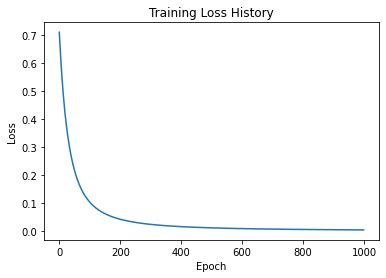

CCS supervised accuracy: 0.6


In [31]:
# Train CCS with labels
ccs_supervised = CCS(neg_hs_train, pos_hs_train)
ccs_supervised.supervised_train(y_train, batch_size=-1, verbose=False, nepochs=1000)
# ccs_supervised.repeated_train()

# Evaluate
ccs_supervised_acc = ccs_supervised.get_acc(neg_hs_test, pos_hs_test, y_test)
print("CCS supervised accuracy: {}".format(ccs_supervised_acc))